In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 123 kB 23.6 MB/s 
     |████████████████████████████████| 90 kB 12.8 MB/s 
     |████████████████████████████████| 132 kB 71.0 MB/s 
     |████████████████████████████████| 79 kB 11.3 MB/s 
     |████████████████████████████████| 8.7 MB 61.6 MB/s 
     |████████████████████████████████| 138 kB 75.8 MB/s 
     |████████████████████████████████| 127 kB 76.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

2022-06-30 18:32:26.827385: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-06-30 18:32:26.827570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/user/anaconda3/envs/test/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

TensorFlow is already loaded. Please restart the runtime to change versions.
Found GPU at: /device:GPU:0


'Tesla T4'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Data Import

In [2]:
df = pd.read_csv("data/data.csv")
df = df.rename(columns={"body": "sentence"})

In [ ]:
df.shape

(13422, 2)

In [ ]:
df.sample(10)

,sentence,label
8254,The fact that I have spent too much time on se...,1
12205,> scumbags\n\nStupid scumbags. Look at their f...,1
1286,"This is interesting, but if I'm at DTD there a...",0
11695,you can actually see it snowing,1
1981,"Sure thing man, I understand. All those Faceb...",0
5959,Where are you buying them from? It's a chain r...,0
9312,Nice to finally hear something regarding China...,1
9356,''The true power lies in the hands of the many...,1
12278,I hope when the house of the note author will ...,1
6624,Yeah I bet it is! Yes I will keep you posted,0


## Data Preprocessing

In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 24683891.67B/s]


Tokenize the first sentence:
['[CLS]', '[', 'deleted', ']', '[SEP]']


In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (620 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (1635 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (617 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (513 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (536 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length 

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## RNN Stega

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 407873900/407873900 [00:06<00:00, 63651491.37B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


## Training

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch.tensor(b_input_ids).to(device).long()
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch.tensor(b_input_ids).to(device).long()
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.5237391479116268


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Epoch:  25%|██▌       | 1/4 [05:09<15:28, 309.59s/it]

Validation Accuracy: 0.7484158986175116
Train loss: 0.3204801756711233


Epoch:  50%|█████     | 2/4 [10:33<10:36, 318.29s/it]

Validation Accuracy: 0.7752016129032258
Train loss: 0.13645008218686575


Epoch:  75%|███████▌  | 3/4 [15:57<05:20, 320.54s/it]

Validation Accuracy: 0.7789458525345623
Train loss: 0.060464709564161404


Epoch: 100%|██████████| 4/4 [21:20<00:00, 320.09s/it]

Validation Accuracy: 0.7521121351766513


In [ ]:
model.eval()
#Export trained model
torch.save(model.state_dict(), 'model.pt')
# torch.save(model.state_dict(), 'model/model2.pt')

## Training Evaluation

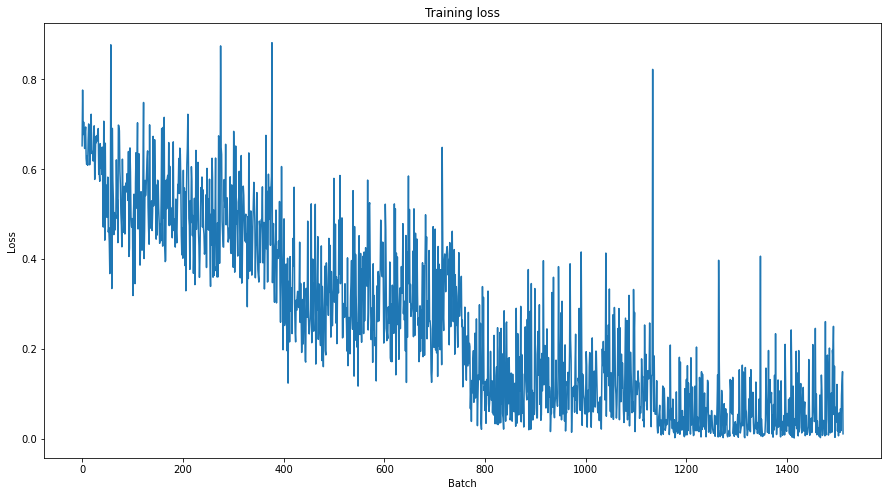

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# **Capsule Network**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import numpy as np

In [ ]:
class Squash(tf.keras.layers.Layer):

  def __init__(self):
    super(Squash,self).__init__()

  def call(self,inputs):

      v_in=tf.norm(inputs,axis=0)

      v_out=(v_in)/(v_in**2+1)

      v_out=tf.math.multiply(inputs,v_out)

      return v_out

class CapsuleModule(tf.keras.layers.Layer):

  def __init__(self,r,dc,nc):
    super(CapsuleModule,self).__init__()
    self.r=r
    self.dc=dc
    self.nc=nc

  def get_config(self):
    config=super().get_config()
    config.update({
        "r1":self.r,
        "dc1":self.dc,
        "nc1":self.nc
    })
    return config



  def build(self,input_shape):
    
    self.squash=Squash()
    self.W=self.add_weight(
        name='W1_capsule',
        shape=(input_shape[2],self.dc),
        trainable=True
    )  

  def call(self,inputs):
    
    shape=inputs.shape

    b=tf.zeros((shape[1],self.nc))

    output=list()

    u=tf.matmul(inputs,self.W)

    for j in range(self.nc):
      
      for _ in range(self.r):

        c=tf.nn.softmax(b,axis=1)
        c=tf.transpose(c)
        c_=tf.expand_dims(c[j],axis=0)
        s=tf.matmul(c_,u)
        g=self.squash(s)
        g_=tf.reshape(g,(-1,g.shape[2],g.shape[1]))
        g_=tf.matmul(u,g_)
        b+=g_
        b=b[0]

      output.append(g)

    return output

class Attention(tf.keras.layers.Layer):

  def __init__(self,dc,comodin):
    super(Attention,self).__init__()
    self.dc=dc
    self.comodin=comodin

  def get_config(self):
    config=super().get_config()
    config.update({
        "dc2":self.dc,
        "comodin1":self.comodin,
    })
    return config  
    
  def build(self,input_shape):

    self.squash=Squash()
    self.attention=MultiHeadAttention(5,100,100)

    self.W=self.add_weight(
        name='W1_att',
        shape=(self.comodin,self.dc),
        trainable=True
    )
    self.W2=self.add_weight(
        name='W2_att',
        shape=(self.comodin,self.dc),
        trainable=True
    )

  def call(self,inputs):

    Global_l,Vc,Vc=inputs

    Att=self.attention(Global_l,tf.matmul(Vc,self.W),tf.matmul(Vc,self.W2))
    Att=self.squash(Att)

    return Att 

class ResidualModule(tf.keras.layers.Layer):

  def __init__(self,dc,nc,do):
    super(ResidualModule,self).__init__()

    self.dc=dc
    self.nc=nc
    self.do=do

  def get_config(self):
    config=super().get_config()
    config.update({
        "dc3":self.dc,
        "nc2":self.nc,
        "do1":self.do
    })
    return config      

  def build(self,input_shape):

    self.flatten=Flatten()

    self.Wc=self.add_weight(
        name='Wc',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

    self.Wl=self.add_weight(
        name='Wl',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

    self.Wco=self.add_weight(
        name='Wco',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

    self.Wlo=self.add_weight(
        name='Wlo',
        shape=(self.nc*self.dc,self.do),
        trainable=True
    )

  def call(self,inputs):

    Global_l,Global_c,Att_l,Att_c=inputs

    Glo_c=tf.matmul(self.flatten(Global_c),self.Wc)
    Glo_l=tf.matmul(self.flatten(Global_l),self.Wl)

    Att_A=tf.nn.relu(tf.matmul(self.flatten(Att_c),self.Wco)+Glo_l)
    Att_B=tf.nn.relu(tf.matmul(self.flatten(Att_l),self.Wlo)+Glo_c)

    return Att_A,Att_B 

class encoding(tf.keras.layers.Layer):

  def __init__(self):
    super(encoding,self).__init__()

  def get_angles(self,pos, i, d_model):

    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
    #return np.dot(pos,angle_rates)

  def positional_encoding(self,position, d_model):
    angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
                            
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = angle_rads[np.newaxis, ...]
  
    return tf.cast(pos_encoding, dtype=tf.float32)
  
  def call(self,inputs):

    shape=inputs.shape

    return inputs+self.positional_encoding(shape[1],shape[2])

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-05-03 16:45:36--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-03 16:45:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-03 16:45:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
data = df[1:10000]
data.head()

,sentence,label
1,Oops. I'll put that in the main thread.,0
2,Np. Feel free to ask me anything,0
3,Come out to Sakht! And just think of Grath's e...,0
4,"This has to be fake, there are no stars behind...",0
5,"[found this, bought one](http://www.ebay.com/i...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 1 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  9999 non-null   object
 1   label     9999 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
def create_dataset_equality(data,key,train_size=0.8):

  '''This is for choosing proportional data'''

  classes=data[key].unique()
  train_list=[]
  test_list=[]

  for cl in classes:
    df=data[data[key]==cl]
    t_size=int(len(df)*train_size)
    df_train=df[:t_size]
    df_test=df[t_size:]

    train_list.append(df_train)
    test_list.append(df_test)

  train_df=pd.concat(train_list,axis=0)
  train_df=train_df.sample(frac=1)
  test_df=pd.concat(test_list,axis=0)  
  test_df=test_df.sample(frac=1)

  return train_df,test_df

In [ ]:
train_df,test_df=create_dataset_equality(data,'label')

train_text=tf.convert_to_tensor(train_df['sentence'].to_list())
y_train=tf.keras.utils.to_categorical(train_df['label'].to_numpy(),num_classes=2)

test_text=tf.convert_to_tensor(test_df['sentence'].to_list())
y_test=tf.keras.utils.to_categorical(test_df['label'].to_numpy(),num_classes=2)

In [ ]:
'''The parameters of our model'''
L=100
V=300
k=12
B=100
gru_units=B
dc=64
do=100
vocab_size=10000
nc=2 #number of classes


vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=L)
text_ds = tf.data.Dataset.from_tensor_slices(train_text).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
x_train=vectorizer(train_text)
x_test=vectorizer(test_text)

In [ ]:
import os
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = V
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9252 words (748 misses)


In [ ]:
def built_model(vocab_size,L,V,k,B,gru_units,dc,categories,do):

  input=Input((L))
  #Feature Extraction Module P1
  m=Embedding(num_tokens,V,input_length=L,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False)(input)
  m=encoding()(m)
  m=tf.expand_dims(m,axis=-1)
  m=Conv2D(B,
           kernel_size=(k,V),
           strides=1)(m)
  shape=m.shape
  M=tf.reshape(m,(-1,shape[1],shape[3]))         

  M=Squash()(M)

  #Feature Extraction Module P2
  
  input_lstm=tf.expand_dims(input,axis=-1)
  H=Bidirectional(GRU(gru_units,return_sequences=True))(input_lstm)
  H=Squash()(H)

  #Capsule Module
  
  Global_l=CapsuleModule(3,dc,categories)(H)#bidirectionalLSTM Global l

  Global_l=tf.concat(Global_l,axis=1)
  
  Global_c=CapsuleModule(3,dc,categories)(M)#N_gram_CNN Global c
  
  Global_c=tf.concat(Global_c,axis=1)

  #Attention module:
  
  Att_l=Attention(dc,B)((Global_l,M,M))

  Att_c=Attention(dc,2*gru_units)((Global_c,H,H))

  #Residual Module:

  Att_A,Att_B=ResidualModule(dc,categories,do)((Global_l,Global_c,Att_l,Att_c))

  V_final=tf.concat((Att_A,Att_B),axis=1)
  
  #FullyConectedLayers:
  V_final=Dropout(0.3)(V_final)
  x=Dense(200,activation='relu')(V_final)
  x=Dense(200,activation='relu')(x)
  output=Dense(categories,activation='softmax',
               kernel_regularizer=tf.keras.regularizers.L2(0.0001),
               activity_regularizer=tf.keras.regularizers.L2(0.0001))(x)
 
  model=Model(input,output)
  
  model.summary()

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'],
                optimizer=tf.keras.optimizers.Adam(1e-3))

  return model


In [ ]:
model=built_model(vocab_size,L,V,k,B,gru_units,dc,nc,do)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     3000600     ['input_3[0][0]']                
                                                                                                  
 encoding_2 (encoding)          (None, 100, 300)     0           ['embedding_2[0][0]']            
                                                                                                  
 tf.expand_dims_4 (TFOpLambda)  (None, 100, 300, 1)  0           ['encoding_2[0][0]']             
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks=[ModelCheckpoint('DGLA_model.h5',save_best_only=True)]

trained = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=32,callbacks=callbacks)

Epoch 1/10
250/250 [==============================] - 13s 51ms/step - loss: 0.4713 - accuracy: 0.7628 - val_loss: 0.5628 - val_accuracy: 0.7175
Epoch 2/10
250/250 [==============================] - 8s 33ms/step - loss: 0.4617 - accuracy: 0.7723 - val_loss: 0.5808 - val_accuracy: 0.6845
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 0.4402 - accuracy: 0.7813 - val_loss: 0.5832 - val_accuracy: 0.7115
Epoch 4/10
250/250 [==============================] - 6s 23ms/step - loss: 0.4385 - accuracy: 0.7826 - val_loss: 0.6518 - val_accuracy: 0.7130
Epoch 5/10
250/250 [==============================] - 6s 23ms/step - loss: 0.4107 - accuracy: 0.7960 - val_loss: 0.6567 - val_accuracy: 0.7110
Epoch 6/10
250/250 [==============================] - 6s 23ms/step - loss: 0.3882 - accuracy: 0.8117 - val_loss: 0.6986 - val_accuracy: 0.6920
Epoch 7/10
250/250 [==============================] - 6s 23ms/step - loss: 0.3766 - accuracy: 0.8201 - val_loss: 0.6625 - val_accuracy: 0.705

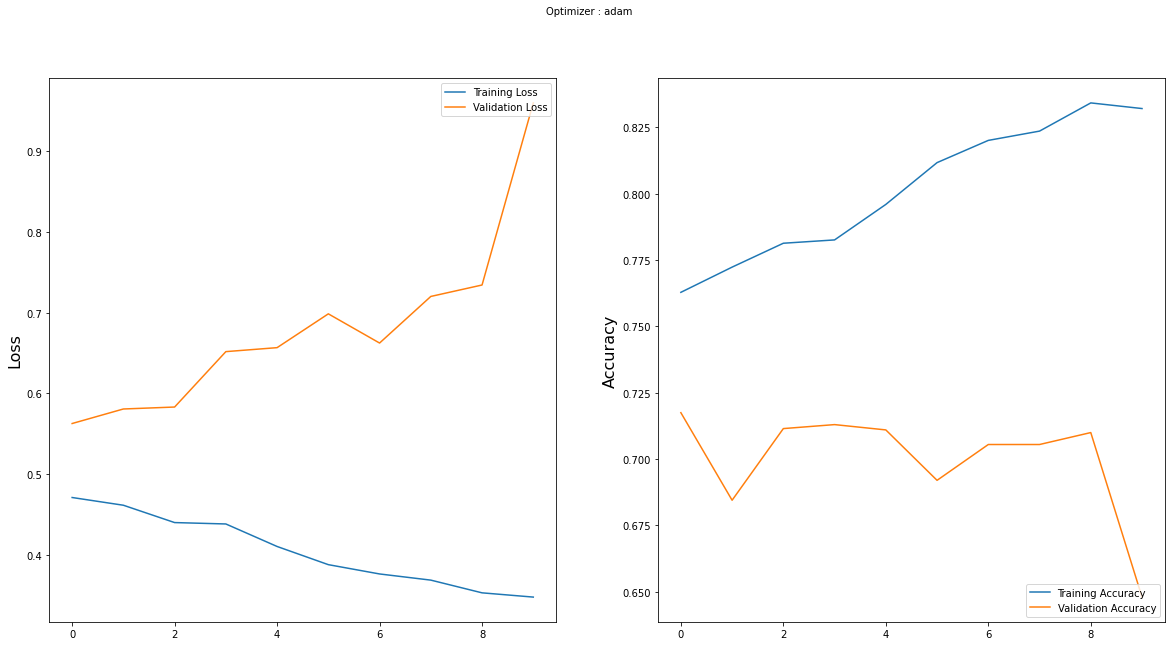

In [ ]:
import matplotlib.pyplot as plt

x= trained
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# **Hybrid Model**

In [3]:
df = df[1:1000]

In [4]:
# Attribute and Labels
tweet_df = df[['sentence','label']]
#tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
X = tweet_df.sentence
y = tweet_df.label

In [5]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
review_labels_train = y_train

In [7]:
# Check Review Labels
review_labels_train

779    0
287    0
166    0
961    0
494    0
      ..
107    0
271    0
861    0
436    0
103    0
Name: label, Length: 799, dtype: int64

In [8]:
# Importing required tf modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab = X_train.values

In [9]:
# Vectorize a text corpus, by turning each text into sequence of integers

tokenizer = Tokenizer(num_words=8000,oov_token='OOV')
tokenizer.fit_on_texts(vocab)

vocab_size = len(tokenizer.word_index) + 1

print(tokenizer)
print(vocab_size)

5458


In [10]:
# Store and Padding Converted Sequences
tweet = X_train.values

tweet_seqs = tokenizer.texts_to_sequences(tweet)

padded_sequence_train = pad_sequences(tweet_seqs, maxlen=200)
print(padded_sequence_train)

[[   0    0    0 ...   12    2  914]
 [   0    0    0 ...  334   58 2098]
 [   0    0    0 ...   13   20  305]
 ...
 [   0    0    0 ...  414   29  372]
 [   0    0    0 ... 1950 5450 5451]
 [   0    0    0 ...  415   11   44]]


In [11]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import MaxPooling1D

embed_dim = 128
lstm_out = 192
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim,input_length = 200))
model2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

2022-06-30 18:33:31.841384: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-30 18:33:31.841497: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-30 18:33:31.841620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ramesh): /proc/driver/nvidia/version does not exist
2022-06-30 18:33:31.913307: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2494415000 Hz
2022-06-30 18:33:31.914439: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56497dfcb6d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-30 18:33:31.914555: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          698624    
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 32)           12320     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 764,245
Trainable params: 764,245
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
trained = model2.fit(padded_sequence_train,review_labels_train,validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
20/20 [==============================] - 28s 1s/step - loss: 0.2789 - accuracy: 0.9452 - val_loss: 9.0830e-04 - val_accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 21s 1s/step - loss: 3.7121e-04 - accuracy: 1.0000 - val_loss: 1.6025e-04 - val_accuracy: 1.0000
Epoch 3/20
20/20 [==============================] - 15s 773ms/step - loss: 1.2549e-04 - accuracy: 1.0000 - val_loss: 1.0268e-04 - val_accuracy: 1.0000
Epoch 4/20
20/20 [==============================] - 11s 546ms/step - loss: 9.2926e-05 - accuracy: 1.0000 - val_loss: 8.4538e-05 - val_accuracy: 1.0000
Epoch 5/20
20/20 [==============================] - 10s 503ms/step - loss: 7.8860e-05 - accuracy: 1.0000 - val_loss: 7.3395e-05 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 10s 506ms/step - loss: 6.9120e-05 - accuracy: 1.0000 - val_loss: 6.4911e-05 - val_accuracy: 1.0000
Epoch 7/20
20/20 [==============================] - 11s 544ms/step - loss: 6.1475e-05 - accuracy: 1.0000

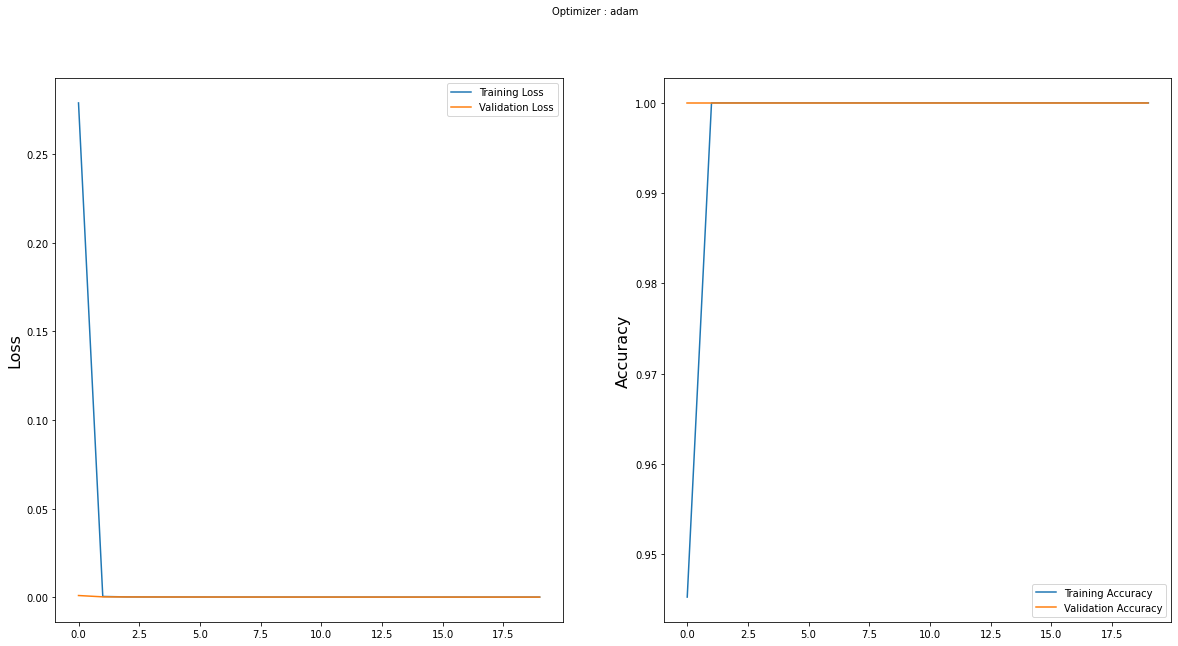

In [13]:
import matplotlib.pyplot as plt

x = trained
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [14]:
model2.save('model.h5')

# Bidirectional LSTM

In [15]:
import numpy as np
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import  Dense, Embedding, LSTM, Bidirectional

In [16]:
model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = 200))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          698624    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 797,569
Trainable params: 797,569
Non-trainable params: 0
_________________________________________________________________


In [18]:
history=model.fit(padded_sequence_train,review_labels_train,validation_split=0.2, epochs=2, batch_size=32)

Epoch 1/2
20/20 [==============================] - 42s 2s/step - loss: 0.3139 - accuracy: 0.9484 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 2/2
20/20 [==============================] - 23s 1s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.2594e-04 - val_accuracy: 1.0000


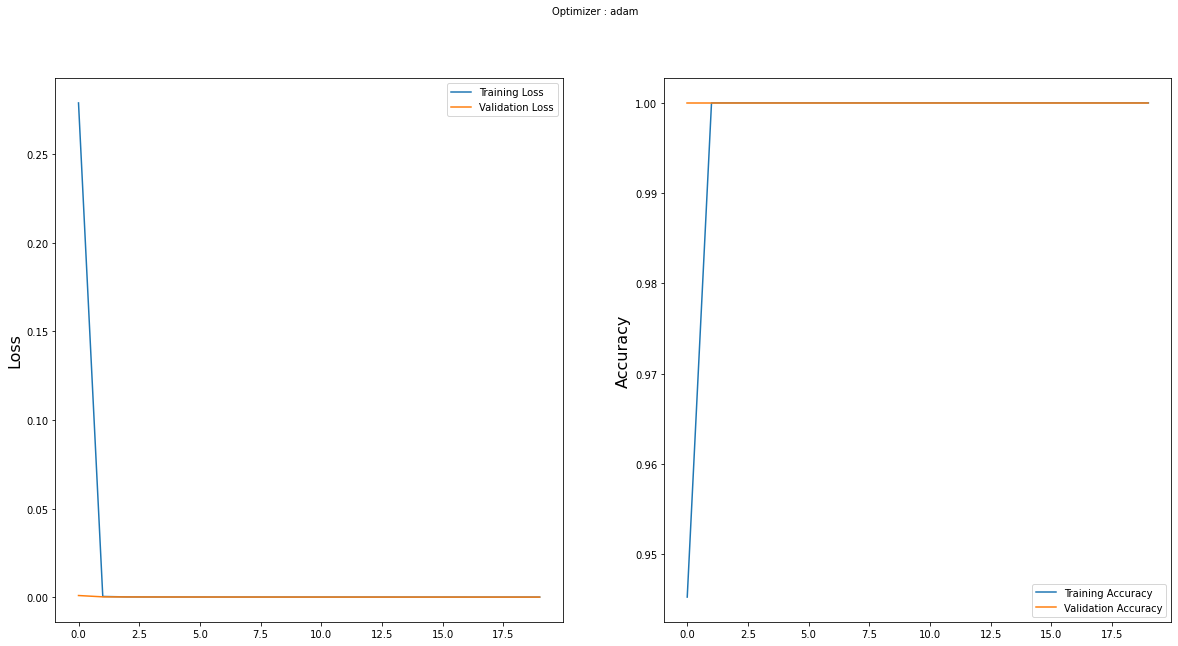

In [19]:
import matplotlib.pyplot as plt

x = trained
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()